In [1]:
import re
import json
import pickle
import nltk
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn import svm
from sklearn.metrics import classification_report, accuracy_score
from sklearn.naive_bayes import MultinomialNB
from tensorflow.keras import layers
from tensorflow.keras.regularizers import L1
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import PiecewiseConstantDecay
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer


%matplotlib inline

In [2]:
STOPWORDS = set(nltk.corpus.stopwords.words('english'))
with open("english_contractions.json", 'r') as f:
    ENGLISH_CONTRACTIONS = json.load(f)
wnl = nltk.WordNetLemmatizer()

def replace_urls(text):
    url_regex = r'(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]+\.[^\s]{2,}|www\.[a-zA-Z0-9]+\.[^\s]{2,})'
    return re.sub(url_regex, "<URL>", text)

def replace_mentions(text):
    username_regex = r'@[\w|\d|_]+'
    return re.sub(username_regex, '<MENTION>', text)


def simplify_punctuation(text):
    corrected = re.sub(r'([!?,;])\1+', r'\1', text)
    corrected = re.sub(r'\.{2,}', r'...', corrected)
    return corrected


def remove_whitespace_duplicate(text):
    corrected = re.sub(r"//t",r"\t", text)
    corrected = re.sub(r"( )\1+",r"\1", corrected)
    corrected = re.sub(r"(\n)\1+",r"\1", corrected)
    corrected = re.sub(r"(\r)\1+",r"\1", corrected)
    corrected = re.sub(r"(\t)\1+",r"\1", corrected)
    return corrected.strip()


def remove_contractions(text):
    tokens = text.split()
    replacement_tokens = [ENGLISH_CONTRACTIONS.get(token, token) for token in tokens]
    return ' '.join(replacement_tokens).strip()


def remove_stop_words(text):
    tokens = text.split()
    replacement_tokens = [token for token in tokens if token not in STOPWORDS]
    return ' '.join(replacement_tokens).strip()


def lemmatize(text):
    tokens = text.split()
    replacement_tokens = [wnl.lemmatize(token) for token in tokens]
    return ' '.join(replacement_tokens).strip()


def cleaning_result(texts):
    text_series = pd.Series(texts)
    text_series = text_series.apply(lambda txt: txt.lower())
    text_series = text_series.apply(replace_mentions)
    text_series = text_series.apply(replace_urls)
    text_series = text_series.apply(simplify_punctuation)
    text_series = text_series.apply(remove_whitespace_duplicate)
    text_series = text_series.apply(remove_contractions)
    text_series = text_series.apply(remove_stop_words)
    text_series = text_series.apply(lemmatize)
    return list(text_series)


def prepare_data():
    df = pd.read_csv('Covid_19_tweets_train.csv', encoding='latin1')
    
    df.fillna(value='Unknown', inplace=True)
        
    df['OriginalTweet'] = cleaning_result(df['OriginalTweet'])

    label_encoder = LabelEncoder()
    
    df['Sentiment'] = label_encoder.fit_transform(df['Sentiment'])
    
    return df, label_encoder


def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()


def plot_freq_bar(x, y, title, scale='linear', figsize=(10, 5), rotation=True):
    fig, ax = plt.subplots(figsize=figsize)
    plt.title(title)
    plt.bar(x, y)
    if rotation:
        plt.setp(ax.get_xticklabels(), rotation=-45, horizontalalignment='left')
    plt.yscale(scale)
    plt.grid()


def plot_pie(sizes, labels, title):
    fig1, ax1 = plt.subplots(figsize=(7, 5))
    ax1.pie(sizes, labels=labels, autopct='%1.2f%%',
            shadow=True, startangle=90)
    ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    ax1.set_title(title, pad=50)
    plt.show()

In [3]:
df, label_encoder = prepare_data()

In [4]:
tweets_corpus = " ".join(df["OriginalTweet"])

In [5]:
from collections import Counter

most_common_counter = Counter(tweets_corpus.split())

most_common = most_common_counter.most_common(20)

most_common_words = [word for word, _ in most_common]
most_common_words_counts = [count for _, count in most_common]

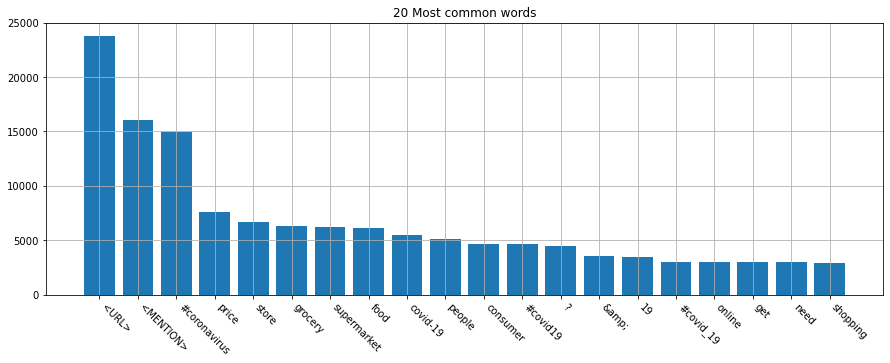

In [6]:
plot_freq_bar(most_common_words, most_common_words_counts, '20 Most common words', figsize=(15, 5))

In [7]:
bigram_measures = nltk.collocations.BigramAssocMeasures()
finder = nltk.BigramCollocationFinder.from_words(nltk.word_tokenize(tweets_corpus))
finder.apply_freq_filter(2)
finder.apply_word_filter(lambda w: len(w) < 3)

In [8]:
most_freq_bigrams = [bigram for bigram, score in finder.score_ngrams(bigram_measures.likelihood_ratio)[:30]]

In [9]:
most_freq_bigrams

[('grocery', 'store'),
 ('toilet', 'paper'),
 ('hand', 'sanitizer'),
 ('panic', 'buying'),
 ('can', 'not'),
 ('online', 'shopping'),
 ('social', 'distancing'),
 ('oil', 'price'),
 ('supply', 'chain'),
 ('stay', 'home'),
 ('food', 'bank'),
 ('covid-19', 'pandemic'),
 ('stay', 'safe'),
 ('front', 'line'),
 ('right', 'now'),
 ('face', 'mask'),
 ('consumer', 'behavior'),
 ('gas', 'price'),
 ('supermarket', 'shelf'),
 ('due', 'covid-19'),
 ('retail', 'store'),
 ('price', 'gouging'),
 ('consumer', 'protection'),
 ('wash', 'hand'),
 ('saudi', 'arabia'),
 ('coronavirus', 'pandemic'),
 ('store', 'worker'),
 ('make', 'sure'),
 ('shopping', 'online'),
 ('local', 'supermarket')]

In [10]:
most_common_hashtags = [word for word, _ in most_common_counter.most_common() if word.startswith('#')][:10]
most_common_hashags_counts = [count for word, count in most_common_counter.most_common() if word.startswith('#')][:10]

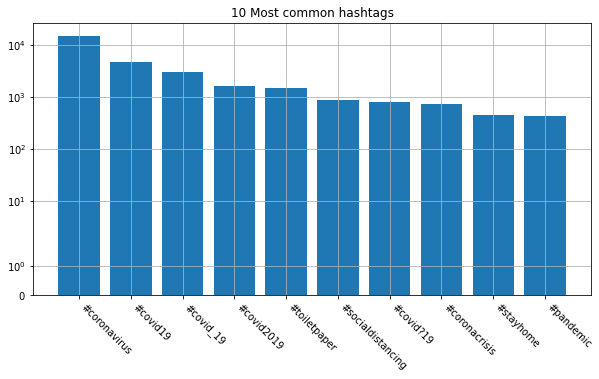

In [11]:
plot_freq_bar(most_common_hashtags, most_common_hashags_counts, '10 Most common hashtags', 'symlog')

In [12]:
location_series = df['Location']
location_series.describe()

count       41157
unique      12220
top       Unknown
freq         8593
Name: Location, dtype: object

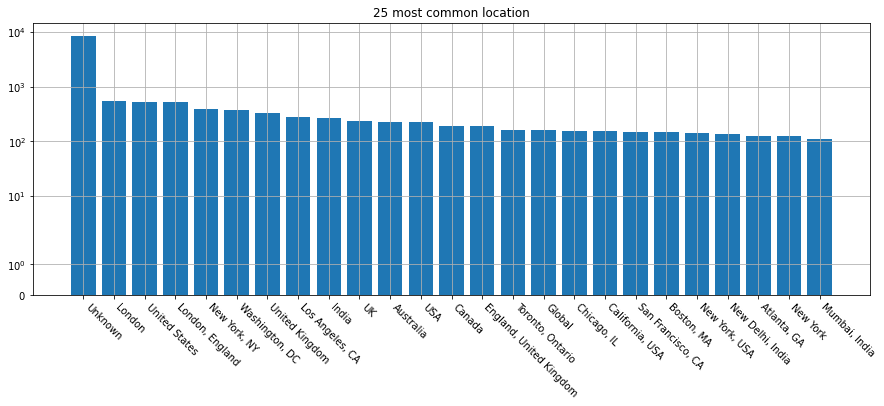

In [13]:
value_count_series = location_series.value_counts()
most_25_location = value_count_series[:25]
plot_freq_bar(most_25_location.index, most_25_location, '25 most common location', figsize=(15, 5), scale='symlog')

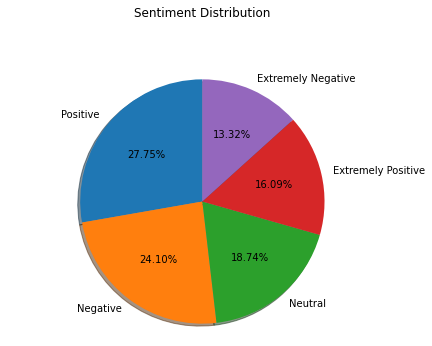

In [22]:
plot_pie(sizes=df['Sentiment'].value_counts(), labels=label_encoder.inverse_transform(df['Sentiment'].value_counts().index), title='Sentiment Distribution')

In [15]:
time_stamp = pd.to_datetime(df['TweetAt'])

df['Year'] = time_stamp.apply(lambda time: time.year)
df['Day'] = time_stamp.apply(lambda time: time.day)
df['Month'] = time_stamp.apply(lambda time: time.month)
df['Day of week'] = time_stamp.apply(lambda time: time.dayofweek)

dmap = {0: "Mon", 1: "Tue", 2: "Wed", 3: "Thu", 4: "Fri",5: "Sat", 6: "Sun"}

df['Day of week'] = df['Day of week'].map(dmap)

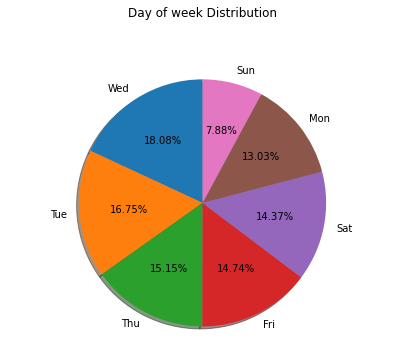

In [16]:
plot_pie(sizes=df['Day of week'].value_counts(), 
         labels=df['Day of week'].value_counts().index, title='Day of week Distribution')

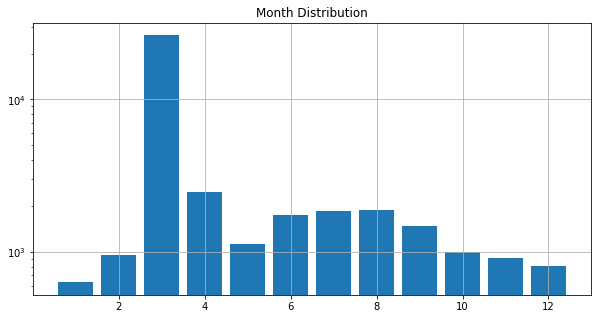

In [17]:
plot_freq_bar(df['Month'].value_counts().index, df['Month'].value_counts(), 'Month Distribution', rotation=False, scale='log')

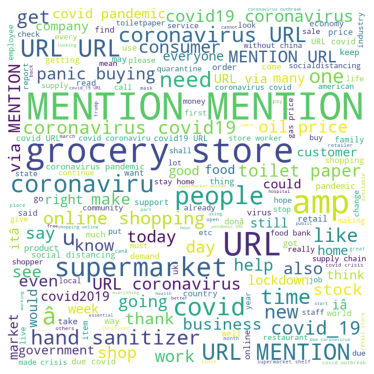

In [18]:
from wordcloud import WordCloud 
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = STOPWORDS, 
                min_font_size = 10).generate(tweets_corpus) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 5), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

In [19]:
no_features = 1000

tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=no_features, stop_words='english')
tf = tf_vectorizer.fit_transform(df['OriginalTweet'])
tf_feature_names = tf_vectorizer.get_feature_names()

In [20]:
from sklearn.decomposition import LatentDirichletAllocation

no_topics = 3

# Run LDA
lda = LatentDirichletAllocation(no_topics, max_iter=5, learning_method='online', learning_offset=50.,random_state=0).fit(tf)

In [21]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print ("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

no_top_words = 10
display_topics(lda, tf_feature_names, no_top_words)

Topic 0:
supermarket food people coronavirus shopping url online need going home
Topic 1:
mention coronavirus store url grocery sanitizer hand covid19 worker supermarket
Topic 2:
url 19 covid price mention consumer coronavirus pandemic demand amp


In [4]:
from nltk.tokenize import sent_tokenize, WhitespaceTokenizer
from nltk.lm.preprocessing import padded_everygram_pipeline
from nltk.lm import MLE

tokenizer = WhitespaceTokenizer()
tweets_corpus = " ".join(df["OriginalTweet"])
tokenized_corpus = sent_tokenize(tweets_corpus)
tokenized_corpus = [tokenizer.tokenize(sent) for sent in tokenized_corpus]
train_data, padded_sents = padded_everygram_pipeline(3, tokenized_corpus)

lm = MLE(3)
lm.fit(train_data, padded_sents)

In [5]:
from nltk.tokenize.treebank import TreebankWordDetokenizer

def generate_sent(lm, num_words, random_seed=42):
    """
    :param model: An ngram language model from `nltk.lm.model`.
    :param num_words: Max no. of words to generate.
    :param random_seed: Seed value for random.
    """
    content = []
    for token in lm.generate(num_words, random_seed=random_seed):
        if token == '<s>':
            continue
        if token == '</s>':
            break
        content.append(token)
    detokenizer = TreebankWordDetokenizer()
    return detokenizer.detokenize(content)

In [6]:
generate_sent(lm, 20, random_seed=5)

'hospital shut &amp; turned overnight tiny grocery store worker mostly.'

In [7]:
generate_sent(lm, 28, random_seed=10)

'full letter ceo <URL> trending australian news story published <MENTION>, <MENTION>, others <URL> <URL> still need groceries.'

In [8]:
sent_train, sent_test, y_train, y_test = train_test_split(df['OriginalTweet'], df['Sentiment'], test_size=0.25, random_state=42)

In [9]:
def evaluate_classifier(clf, X, y):
    y_pred = clf.predict(X)

    print(classification_report(y, y_pred, target_names=label_encoder.classes_))
    
    print('-----------------------------------------------------------------------------')

In [10]:
tfidf = TfidfVectorizer(min_df=2, max_df=0.5, ngram_range=(1, 2))
tfidf.fit(sent_train)
X_train, X_test = tfidf.transform(sent_train), tfidf.transform(sent_test)

In [11]:
X_train, X_test = tfidf.transform(sent_train), tfidf.transform(sent_test)

In [12]:
# tfidf_clf = svm.NuSVC(gamma='auto')
# tfidf_clf.fit(X_train, y_train)
tfidf_clf = pickle.load(open('tfidf_clf.pkl', 'rb'))
evaluate_classifier(tfidf_clf, X_train, y_train)
evaluate_classifier(tfidf_clf, X_test, y_test)

                    precision    recall  f1-score   support

Extremely Negative       0.64      0.16      0.25      4164
Extremely Positive       0.49      0.70      0.58      4981
          Negative       0.39      0.68      0.49      7404
           Neutral       0.60      0.21      0.31      5794
          Positive       0.45      0.41      0.43      8524

          accuracy                           0.45     30867
         macro avg       0.51      0.43      0.41     30867
      weighted avg       0.50      0.45      0.42     30867

-----------------------------------------------------------------------------
                    precision    recall  f1-score   support

Extremely Negative       0.57      0.14      0.23      1317
Extremely Positive       0.44      0.64      0.52      1643
          Negative       0.36      0.61      0.45      2513
           Neutral       0.53      0.21      0.31      1919
          Positive       0.38      0.33      0.35      2898

          accurac

In [13]:
bayes_clf = MultinomialNB()
bayes_clf.fit(X_train, y_train)
evaluate_classifier(bayes_clf, X_train, y_train)
evaluate_classifier(bayes_clf, X_test, y_test)

                    precision    recall  f1-score   support

Extremely Negative       0.98      0.18      0.31      4164
Extremely Positive       0.99      0.25      0.40      4981
          Negative       0.66      0.82      0.73      7404
           Neutral       0.96      0.46      0.62      5794
          Positive       0.49      0.98      0.66      8524

          accuracy                           0.62     30867
         macro avg       0.81      0.54      0.54     30867
      weighted avg       0.76      0.62      0.58     30867

-----------------------------------------------------------------------------
                    precision    recall  f1-score   support

Extremely Negative       0.81      0.06      0.11      1317
Extremely Positive       0.86      0.07      0.12      1643
          Negative       0.41      0.42      0.42      2513
           Neutral       0.81      0.15      0.25      1919
          Positive       0.36      0.87      0.51      2898

          accurac

In [14]:
bow = CountVectorizer()
bow.fit(sent_train)
X_train, X_test = bow.transform(sent_train), bow.transform(sent_test)

In [15]:
# bow_clf = svm.NuSVC(gamma='auto')
# bow_clf.fit(X_train, y_train)
bow_clf = pickle.load(open('bow_clf.pkl', 'rb'))
evaluate_classifier(bow_clf, X_train, y_train)
evaluate_classifier(bow_clf, X_test, y_test)

                    precision    recall  f1-score   support

Extremely Negative       0.84      0.71      0.77      4164
Extremely Positive       0.88      0.76      0.82      4981
          Negative       0.78      0.80      0.79      7404
           Neutral       0.77      0.87      0.82      5794
          Positive       0.80      0.83      0.82      8524

          accuracy                           0.80     30867
         macro avg       0.81      0.79      0.80     30867
      weighted avg       0.81      0.80      0.80     30867

-----------------------------------------------------------------------------
                    precision    recall  f1-score   support

Extremely Negative       0.64      0.51      0.57      1317
Extremely Positive       0.74      0.60      0.66      1643
          Negative       0.55      0.55      0.55      2513
           Neutral       0.62      0.78      0.69      1919
          Positive       0.61      0.61      0.61      2898

          accurac

In [17]:
bow_bayes_clf = MultinomialNB()
bow_bayes_clf.fit(X_train, y_train)
evaluate_classifier(bow_bayes_clf, X_train, y_train)
evaluate_classifier(bow_bayes_clf, X_test, y_test)

                    precision    recall  f1-score   support

Extremely Negative       0.89      0.66      0.76      4164
Extremely Positive       0.85      0.71      0.77      4981
          Negative       0.71      0.80      0.75      7404
           Neutral       0.88      0.63      0.73      5794
          Positive       0.66      0.87      0.75      8524

          accuracy                           0.75     30867
         macro avg       0.80      0.73      0.75     30867
      weighted avg       0.78      0.75      0.75     30867

-----------------------------------------------------------------------------
                    precision    recall  f1-score   support

Extremely Negative       0.59      0.34      0.43      1317
Extremely Positive       0.60      0.41      0.49      1643
          Negative       0.41      0.50      0.45      2513
           Neutral       0.68      0.35      0.46      1919
          Positive       0.42      0.63      0.50      2898

          accurac

In [18]:
y_train, y_test = to_categorical(y_train), to_categorical(y_test)

Let us start with a simple feed forward neural network as our NN baseline


In [19]:
def build_baseline(input_shape, name='baseline'):
    with tf.device('/device:GPU:0'):
        input_layer = layers.Input(shape=input_shape)
        g = layers.Dense(128, activation='relu')(input_layer)
        g = layers.Dense(label_encoder.classes_.shape[0], activation='softmax')(g)
        
        clf = Model(inputs=input_layer, outputs=g, name=name)
        
        clf.compile(loss='categorical_crossentropy', 
                      optimizer='adam', 
                      metrics=['accuracy'])
        
        print(clf.summary())
    
    return clf

In [13]:
def fit_nn_classifier(clf, epochs, X_train, X_test, validation_split=0.2, verbose=0):
    with tf.device('/device:GPU:0'):
        history = clf.fit(X_train, y_train, validation_split=validation_split, batch_size=256, epochs=epochs, verbose=verbose)

        y_pred = clf.predict(X_test)
    
    print('--------------------------------------------------------------------------------------------')
    
    y_pred_sk = np.argmax(y_pred, axis=1)
    
    y_test_sk = np.argmax(y_test, axis=1)

    print(classification_report(y_test_sk, y_pred_sk, target_names=label_encoder.classes_))
    
    return history

Lets see how our network perform on BOW features

In [21]:
baseline_clf = build_baseline(X_train.shape[1], 'bow_baseline')
baseline_history = fit_nn_classifier(baseline_clf, 6, X_train, X_test, None, verbose=1)

Model: "bow_baseline"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 39023)]           0         
_________________________________________________________________
dense (Dense)                (None, 128)               4995072   
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 645       
Total params: 4,995,717
Trainable params: 4,995,717
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/6
121/121 [==============================] - 1s 5ms/step - loss: 1.3017 - accuracy: 0.4551
Epoch 2/6
121/121 [==============================] - 1s 5ms/step - loss: 0.7433 - accuracy: 0.7639
Epoch 3/6
121/121 [==============================] - 1s 5ms/step - loss: 0.4462 - accuracy: 0.8780
Epoch 4/6
121/121 [==============================] - 1s 5ms/step - loss:

Now we can easily see that our model fell into overfit and really fast (with only 6 epoch!!)

We will try to overcome this by adding more Dense layers and Dropout regularizer. Additionally we will build the model in an encoder-decoder architecture

In [22]:
def build_nn_1(input_shape, loss, name='ffn_clf'):
    with tf.device('/device:GPU:0'):
        input_layer = layers.Input(shape=input_shape)
        g = layers.Dense(512, activation='relu')(input_layer)
        g = layers.Dropout(0.2)(g)
        g = layers.Dense(256, activation='relu')(g)
        g = layers.Dropout(0.3)(g)
        g = layers.Dense(128, activation='relu')(g)
        g = layers.Dropout(0.2)(g)
        g = layers.Dense(256, activation='relu')(g)
        g = layers.Dense(512, activation='relu')(g)
        g = layers.Dropout(0.2)(g)
        g = layers.Dense(label_encoder.classes_.shape[0], activation='softmax')(g)
        
        clf = Model(inputs=input_layer, outputs=g, name=name)
        
        clf.compile(loss=loss, 
                      optimizer='adam', 
                      metrics=['accuracy'])
        
        print(clf.summary())
    
    return clf

In [23]:
bow_nn_clf = build_nn_1(X_train.shape[1], 'categorical_crossentropy')
bow_nn_history = fit_nn_classifier(bow_nn_clf, 6, X_train, X_test, None, verbose=1)

Model: "ffn_clf"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 39023)]           0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               19980288  
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0   

we observe that this is the limit of BOW.

Let us throw the BOW vectorizer and add some feature extraction techniques to our model and see if it can improve.

In [24]:
pd.Series([len(x) for x in df['OriginalTweet']]).describe()

count    41157.000000
mean       145.657798
std         52.290276
min          2.000000
25%        105.000000
50%        151.000000
75%        187.000000
max        291.000000
dtype: float64

we can see that the tweets length have a high deviation so we will choose a maximum of 100 for our train/test sequences.


In [25]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(sent_train)

X_train = tokenizer.texts_to_sequences(sent_train)
X_test = tokenizer.texts_to_sequences(sent_test)

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

print('vocab size',vocab_size)
print(sent_train[2])
print(X_train[2])
print('-----------------------------------------------------------------------------------')
maxlen = 100
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

print(X_train[2, :])

vocab size 40816
coronavirus australia: woolworth give elderly, disabled dedicated shopping hour amid covid-19 outbreak <URL>
[1606, 5, 4, 223, 4, 2, 223, 1286]
-----------------------------------------------------------------------------------
[1606    5    4  223    4    2  223 1286    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]


In [26]:
def build_nn_2(input_shape, embedding_output_dim, loss, name='sequence_encoder_decoder_clf'):
    with tf.device('/device:GPU:0'):
        input_layer = layers.Input(shape=input_shape)
        embedding = layers.Embedding(input_dim=vocab_size, output_dim=embedding_output_dim)(input_layer)
        g = layers.Flatten()(embedding)
        g = layers.Dense(512, activation='relu')(g)
        g = layers.Dropout(0.2)(g)
        g = layers.Dense(256, activation='relu')(g)
        g = layers.Dropout(0.3)(g)
        g = layers.Dense(128, activation='relu')(g)
        g = layers.Dropout(0.2)(g)
        g = layers.Dense(256, activation='relu')(g)
        g = layers.Dense(512, activation='relu')(g)
        g = layers.Dropout(0.2)(g)
        g = layers.Dense(label_encoder.classes_.shape[0], activation='softmax')(g)
        
        clf = Model(inputs=input_layer, outputs=g, name=name)
        
        clf.compile(loss=loss, 
                      optimizer='adam', 
                      metrics=['accuracy'])
        
        print(clf.summary())
    
    return clf

def build_nn_3(input_shape, embedding_output_dim, loss, name='sequence_ffn_clf'):
    with tf.device('/device:GPU:0'):
        input_layer = layers.Input(shape=input_shape)
        embedding = layers.Embedding(input_dim=vocab_size, output_dim=embedding_output_dim)(input_layer)
        g = layers.Flatten()(embedding)
        g = layers.Dense(128, activation='relu')(g)
        g = layers.Dropout(0.2)(g)
        g = layers.Dense(256, activation='relu')(g)
        g = layers.Dense(512, activation='relu')(g)
        g = layers.Dropout(0.2)(g)
        g = layers.Dense(label_encoder.classes_.shape[0], activation='softmax')(g)
        
        clf = Model(inputs=input_layer, outputs=g, name=name)
        
        clf.compile(loss=loss, 
                      optimizer='adam', 
                      metrics=['accuracy'])
        
        print(clf.summary())
    
    return clf

Model: "sequence_encoder_decoder_clf"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 100, 32)           1306112   
_________________________________________________________________
flatten (Flatten)            (None, 3200)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 512)               1638912   
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_5 (Dropout)          (None, 25

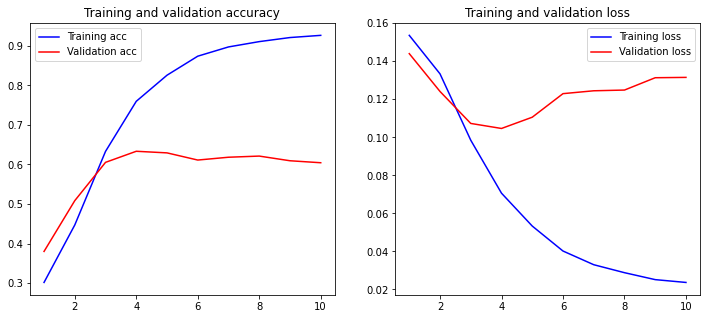

In [27]:
auto_encoder_clf = build_nn_2(maxlen, 32, 'mse')
auto_encoder_history = fit_nn_classifier(auto_encoder_clf, 10, X_train, X_test)
plot_history(auto_encoder_history)

Model: "sequence_encoder_decoder_clf"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 100, 32)           1306112   
_________________________________________________________________
flatten_1 (Flatten)          (None, 3200)              0         
_________________________________________________________________
dense_14 (Dense)             (None, 512)               1638912   
_________________________________________________________________
dropout_8 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_9 (Dropout)          (None, 25

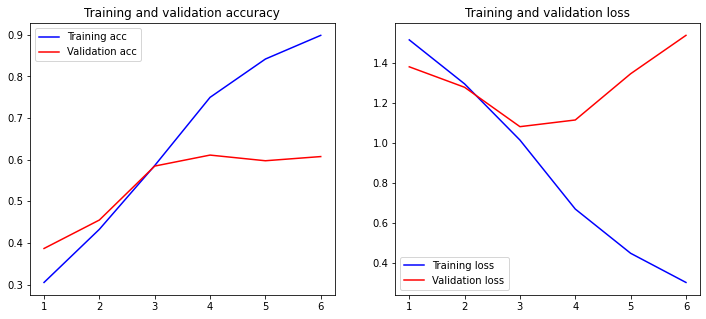

In [28]:
categorical_clf1 = build_nn_2(maxlen, 32, 'categorical_crossentropy')
categorical_clf_history = fit_nn_classifier(categorical_clf1, 6, X_train, X_test)
plot_history(categorical_clf_history)

Model: "sequence_ffn_clf"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 100, 100)          4081600   
_________________________________________________________________
flatten_2 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_20 (Dense)             (None, 128)               1280128   
_________________________________________________________________
dropout_12 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 256)               33024     
_________________________________________________________________
dense_22 (Dense)             (None, 512)          

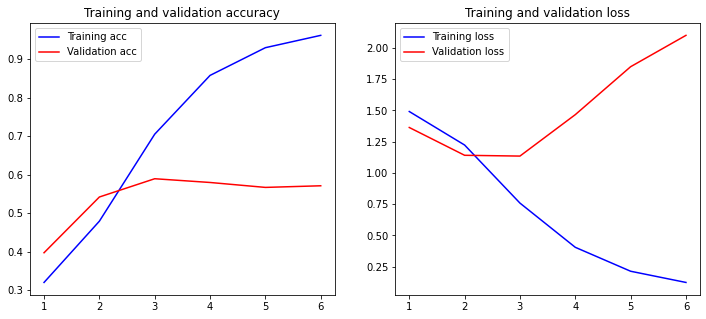

In [29]:
categorical_clf2 = build_nn_3(maxlen, 100, 'categorical_crossentropy')
categorical_clf2_history = fit_nn_classifier(categorical_clf2, 6, X_train, X_test)
plot_history(categorical_clf2_history)

we can see that the embedding layer alone can't boost our model so we are going to use more powerfull feature extraction techniques.

Also the model still overfit the data so clearly we need more regularizers.

In [30]:
def build_cnn_1(input_shape, embedding_output_dim, loss='categorical_crossentropy', name='sequence_cnn_clf'):
    with tf.device('/device:GPU:0'):
        input_layer = layers.Input(shape=input_shape)
        embedding = layers.Embedding(input_dim=vocab_size, output_dim=embedding_output_dim)(input_layer)
        g = layers.SpatialDropout1D(0.2)(embedding)
        g = layers.Conv1D(128, 3, activation='relu', kernel_regularizer=L1())(g)
        g = layers.SpatialDropout1D(0.3)(g)
        g = layers.Flatten()(g)
        g = layers.Dense(128, activation='relu')(g)
        g = layers.Dropout(0.2)(g)
        g = layers.Dense(label_encoder.classes_.shape[0], activation='softmax')(g)
        
        clf = Model(inputs=input_layer, outputs=g, name=name)
        
        clf.compile(loss=loss, 
                      optimizer='adam', 
                      metrics=['accuracy'])
        
        print(clf.summary())
    
    return clf

Model: "sequence_cnn_clf"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 100, 100)          4081600   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 100, 100)          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 98, 128)           38528     
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 98, 128)           0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 12544)             0         
_________________________________________________________________
dense_24 (Dense)             (None, 128)          

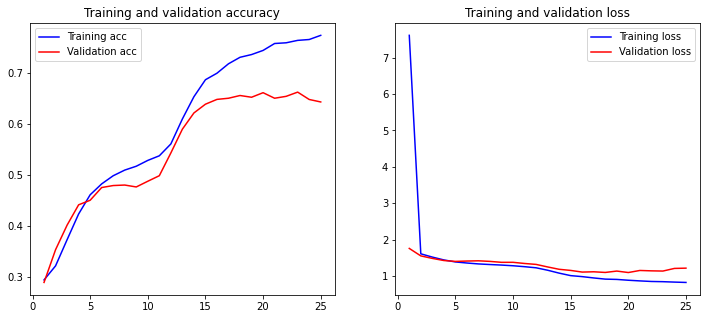

In [31]:
cnn_clf1 = build_cnn_1(maxlen, 100)
history = fit_nn_classifier(cnn_clf1, 25, X_train, X_test, 0.2)
plot_history(history)

In [32]:
def build_cnn_2(input_shape, embedding_output_dim, loss='categorical_crossentropy', name='sequence_cnn_clf'):
    with tf.device('/device:GPU:0'):
        input_layer = layers.Input(shape=input_shape)
        embedding = layers.Embedding(input_dim=vocab_size, output_dim=embedding_output_dim)(input_layer)
        g = layers.SpatialDropout1D(0.2)(embedding)
        g = layers.Conv1D(64, 3, activation='relu')(g)
        g = layers.SpatialDropout1D(0.3)(g)
        g = layers.Conv1D(128, 5, activation='tanh', kernel_regularizer=L1())(g)
        g = layers.GlobalMaxPool1D()(g)
        g = layers.Dense(128, activation='relu')(g)
        g = layers.Dropout(0.2)(g)
        g = layers.Dense(64, activation='relu')(g)
        g = layers.Dense(label_encoder.classes_.shape[0], activation='softmax')(g)
        
        clf = Model(inputs=input_layer, outputs=g, name=name)
        
        clf.compile(loss=loss, 
                      optimizer='adam', 
                      metrics=['accuracy'])
        
        print(clf.summary())
    
    return clf

Model: "cnn_max_clf"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 100, 100)          4081600   
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 100, 100)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 98, 64)            19264     
_________________________________________________________________
spatial_dropout1d_3 (Spatial (None, 98, 64)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 94, 128)           41088     
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               

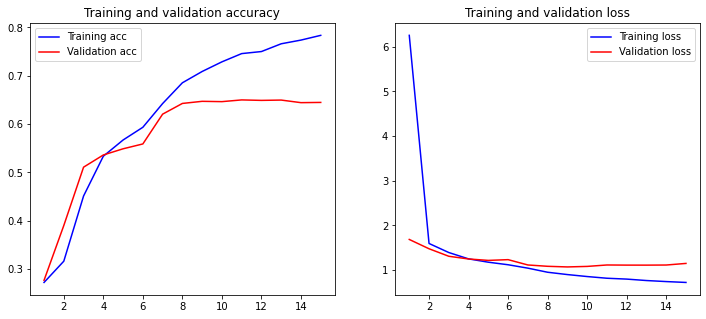

In [33]:
cnn_clf2 = build_cnn_2(maxlen, 100, name='cnn_max_clf')
cnn1_history = fit_nn_classifier(cnn_clf2, 15, X_train, X_test, 0.2)
plot_history(cnn1_history)

Even convolutional layers can't help, so we will use the big guns... LSTM

In [34]:
def build_lstm_baseline(input_shape, embedding_output_dim, loss='categorical_crossentropy', name='sequence_cnn_clf'):
    with tf.device('/device:GPU:0'):
        input_layer = layers.Input(shape=input_shape)
        embedding = layers.Embedding(input_dim=vocab_size, output_dim=embedding_output_dim)(input_layer)
        g = layers.SpatialDropout1D(0.2)(embedding)
        g = layers.Bidirectional(layers.LSTM(128))(g)
        g = layers.Dense(128, activation='relu')(g)
        g = layers.Dense(label_encoder.classes_.shape[0], activation='softmax')(g)
        
        clf = Model(inputs=input_layer, outputs=g, name=name)
        
        clf.compile(loss=loss, 
                      optimizer='adam', 
                      metrics=['accuracy'])
        
        print(clf.summary())
    
    return clf

Model: "lstm_baseline_clf"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
embedding_5 (Embedding)      (None, 100, 100)          4081600   
_________________________________________________________________
spatial_dropout1d_4 (Spatial (None, 100, 100)          0         
_________________________________________________________________
bidirectional (Bidirectional (None, 256)               234496    
_________________________________________________________________
dense_29 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_30 (Dense)             (None, 5)                 645       
Total params: 4,349,637
Trainable params: 4,349,637
Non-trainable params: 0
_______________________________________

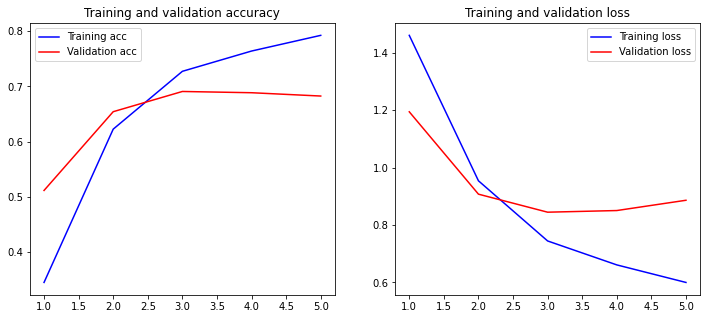

In [35]:
lstm_baseline_clf = build_lstm_baseline(maxlen, 100, name='lstm_baseline_clf')
lstm_baseline_history = fit_nn_classifier(lstm_baseline_clf, 5, X_train, X_test, 0.2)
plot_history(lstm_baseline_history)

Our lstm baseline is the best model so far, let us see how it can improve

In [27]:
def build_lstm(input_shape, embedding_output_dim, loss='categorical_crossentropy', name='sequence_lstm_clf'):
    with tf.device('/device:GPU:0'):
        input_layer = layers.Input(shape=input_shape)
        embedding = layers.Embedding(input_dim=vocab_size, output_dim=embedding_output_dim)(input_layer)
        g = layers.SpatialDropout1D(0.2)(embedding)
        g = layers.Bidirectional(layers.LSTM(128))(g)
        g = layers.Dense(128, activation='relu')(g)
        g = layers.Dropout(0.3)(g)
        g = layers.Dense(64, activation='relu')(g)
        g = layers.Dropout(0.2)(g)
        g = layers.Dense(label_encoder.classes_.shape[0], activation='softmax')(g)
        
        clf = Model(inputs=input_layer, outputs=g, name=name)
        
        clf.compile(loss=loss, 
                      optimizer='adam', 
                      metrics=['accuracy'])
        
        print(clf.summary())
    
    return clf

def build_cnn_lstm_1(input_shape, embedding_output_dim, loss='categorical_crossentropy', name='sequence_cnn_lstm_clf_1'):
    with tf.device('/device:GPU:0'):
        input_layer = layers.Input(shape=input_shape)
        embedding = layers.Embedding(input_dim=vocab_size, output_dim=embedding_output_dim)(input_layer)
        g = layers.SpatialDropout1D(0.2)(embedding)
        g = layers.Conv1D(128, 3)(g)
        g = layers.Bidirectional(layers.LSTM(128))(g)
        g = layers.Dense(128, activation='relu')(g)
        g = layers.Dropout(0.3)(g)
        g = layers.Dense(64, activation='relu')(g)
        g = layers.Dropout(0.2)(g)
        g = layers.Dense(label_encoder.classes_.shape[0], activation='softmax')(g)
        
        clf = Model(inputs=input_layer, outputs=g, name=name)
        
        clf.compile(loss=loss, 
                      optimizer='adam', 
                      metrics=['accuracy'])
        
        print(clf.summary())
    
    return clf

def build_cnn_lstm_2(input_shape, embedding_output_dim, loss='categorical_crossentropy', name='sequence_cnn_lstm_clf_2'):
    with tf.device('/device:GPU:0'):
        input_layer = layers.Input(shape=input_shape)
        embedding = layers.Embedding(input_dim=vocab_size, output_dim=embedding_output_dim)(input_layer)
        g = layers.SpatialDropout1D(0.2)(embedding)
        g = layers.Conv1D(128, 3, activation='tanh', kernel_regularizer=L1())(g)
        g = layers.Conv1D(128, 5, activation='relu')(g)
        g = layers.SpatialDropout1D(0.2)(g)
        g = layers.Conv1D(128, 7, activation='relu')(g)
        g = layers.Bidirectional(layers.LSTM(128))(g)
        g = layers.Dense(128, activation='relu')(g)
        g = layers.Dropout(0.3)(g)
        g = layers.Dense(64, activation='relu')(g)
        g = layers.Dropout(0.2)(g)
        g = layers.Dense(label_encoder.classes_.shape[0], activation='softmax')(g)
        
        clf = Model(inputs=input_layer, outputs=g, name=name)
        
        clf.compile(loss=loss, 
                      optimizer='adam', 
                      metrics=['accuracy'])
        
        print(clf.summary())
    
    return clf

In [37]:
lstm_clf = build_lstm(maxlen, 100)
lstm_clf_history = fit_nn_classifier(lstm_clf, 5, X_train, X_test, 0.2)

Model: "sequence_lstm_clf"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
embedding_6 (Embedding)      (None, 100, 100)          4081600   
_________________________________________________________________
spatial_dropout1d_5 (Spatial (None, 100, 100)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               234496    
_________________________________________________________________
dense_31 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_16 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_32 (Dense)             (None, 64)          

In [38]:
cnn_lstm_clf = build_cnn_lstm_1(maxlen, 100)
cnn_lstm_clf_history = fit_nn_classifier(cnn_lstm_clf, 5, X_train, X_test, 0.2)

Model: "sequence_cnn_lstm_clf_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 100)]             0         
_________________________________________________________________
embedding_7 (Embedding)      (None, 100, 100)          4081600   
_________________________________________________________________
spatial_dropout1d_6 (Spatial (None, 100, 100)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 98, 128)           38528     
_________________________________________________________________
bidirectional_2 (Bidirection (None, 256)               263168    
_________________________________________________________________
dense_34 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_18 (Dropout)         (None, 128)   

In [39]:
cnn_lstm_clf2 = build_cnn_lstm_2(maxlen, 100)
cnn_lstm_clf_history2 = fit_nn_classifier(cnn_lstm_clf2, 20, X_train, X_test, 0.2)

Model: "sequence_cnn_lstm_clf_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 100)]             0         
_________________________________________________________________
embedding_8 (Embedding)      (None, 100, 100)          4081600   
_________________________________________________________________
spatial_dropout1d_7 (Spatial (None, 100, 100)          0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 98, 128)           38528     
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 94, 128)           82048     
_________________________________________________________________
spatial_dropout1d_8 (Spatial (None, 94, 128)           0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 88, 128

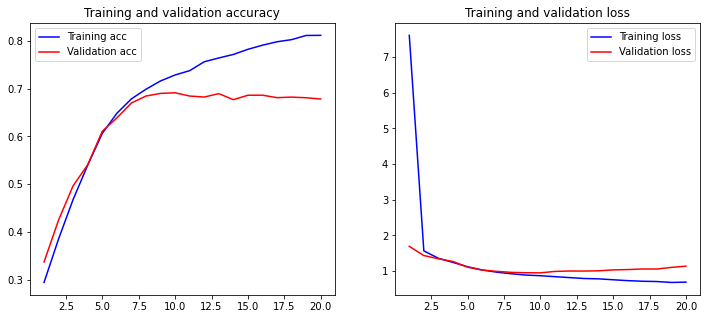

In [59]:
plot_history(cnn_lstm_clf_history2)

So now we have tried different models and techniques with no improvement so clearly there is a problem with our data.

Lets go back and try to feed raw data to our model

In [49]:
def prepare_raw_data():
    df = pd.read_csv('Covid_19_tweets_train.csv', encoding='latin1')
    
    df.fillna(value='Unknown', inplace=True)
        
    text_series = df['OriginalTweet']
    text_series = text_series.apply(replace_mentions)
    text_series = text_series.apply(replace_urls)
    text_series = text_series.apply(simplify_punctuation)
    text_series = text_series.apply(remove_whitespace_duplicate)
    text_series = text_series.apply(remove_contractions)
    
    df['OriginalTweet'] = text_series

    label_encoder = LabelEncoder()
    
    df['Sentiment'] = label_encoder.fit_transform(df['Sentiment'])
    
    return df, label_encoder

In [66]:
df, label_encoder = prepare_raw_data()

In [67]:
sent_train, sent_test, y_train, y_test = train_test_split(df['OriginalTweet'], df['Sentiment'], test_size=0.25, random_state=42)

In [68]:
pd.Series([len(x) for x in df['OriginalTweet']]).describe()

count    41157.000000
mean       190.218894
std         66.655485
min          3.000000
25%        137.000000
50%        202.000000
75%        249.000000
max        311.000000
dtype: float64

In [69]:
y_train, y_test = to_categorical(y_train), to_categorical(y_test)

In [11]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(sent_train)

X_train = tokenizer.texts_to_sequences(sent_train)
X_test = tokenizer.texts_to_sequences(sent_test)

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

print('vocab size',vocab_size)
print(sent_train[2])
print(X_train[2])
print('-----------------------------------------------------------------------------------')
maxlen = 100
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

print(X_train[2, :])

vocab size 42026
Coronavirus Australia: Woolworths to give elderly, disabled dedicated shopping hours amid COVID-19 outbreak <URL>
[1741, 5, 11, 10, 316, 10, 8, 316, 65, 1381, 896]
-----------------------------------------------------------------------------------
[1741    5   11   10  316   10    8  316   65 1381  896    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]


In [71]:
cnn_lstm_clf_raw = build_cnn_lstm_1(maxlen, 100, name='raw_cnn_lstm')
cnn_lstm_clf_raw_history = fit_nn_classifier(cnn_lstm_clf_raw, 5, X_train, X_test, 0.2)

Model: "raw_cnn_lstm"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 100)]             0         
_________________________________________________________________
embedding_10 (Embedding)     (None, 100, 100)          4202600   
_________________________________________________________________
spatial_dropout1d_18 (Spatia (None, 100, 100)          0         
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 98, 128)           38528     
_________________________________________________________________
bidirectional_14 (Bidirectio (None, 256)               263168    
_________________________________________________________________
dense_29 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_20 (Dropout)         (None, 128)              

We see that the model scored better when trained on raw data, yet the improvement is't that noticable, we will turn the problem to binary classification and merge the classes into (Positive, Negetive) in the following manner:

- Negetive < 3
- Positive >= 3

In [16]:
def prepare_raw_binary_data():
    df = pd.read_csv('Covid_19_tweets_train.csv', encoding='latin1')
    
    df.fillna(value='Unknown', inplace=True)
        
    text_series = df['OriginalTweet']
    text_series = text_series.apply(replace_mentions)
    text_series = text_series.apply(replace_urls)
    text_series = text_series.apply(simplify_punctuation)
    text_series = text_series.apply(remove_whitespace_duplicate)
    text_series = text_series.apply(remove_contractions)
    
    df['OriginalTweet'] = text_series
    
    sentiment_series = df['Sentiment'].copy()
    
    sentiment_series[sentiment_series == 'Extremely Negative'] = 'Negative'

    sentiment_series[sentiment_series == 'Neutral'] = 'Positive'

    sentiment_series[sentiment_series == 'Extremely Positive'] = 'Positive'
    
    df['Sentiment'] = sentiment_series
    
    label_encoder = LabelEncoder()
    
    df['Sentiment'] = label_encoder.fit_transform(df['Sentiment'])
        
    return df, label_encoder

In [17]:
df ,label_encoder = prepare_raw_binary_data()

Let's see how the sentiment is distributed now!

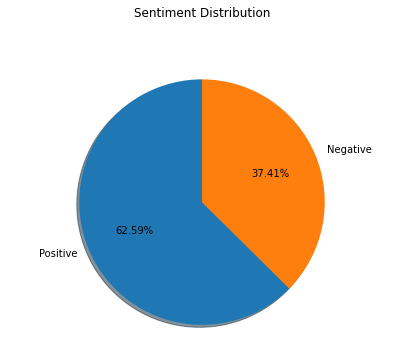

In [18]:
plot_pie(sizes=df['Sentiment'].value_counts(), 
         labels=label_encoder.inverse_transform(df['Sentiment'].value_counts().index), 
         title='Sentiment Distribution')

In [19]:
sent_train, sent_test, y_train, y_test = train_test_split(df['OriginalTweet'], df['Sentiment'], test_size=0.25, random_state=42)

In [20]:
y_train, y_test = to_categorical(y_train), to_categorical(y_test)

In [21]:
X_train = tokenizer.texts_to_sequences(sent_train)
X_test = tokenizer.texts_to_sequences(sent_test)

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

Model: "raw_binary_cnn_lstm"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 100)]             0         
_________________________________________________________________
embedding_8 (Embedding)      (None, 100, 100)          4202600   
_________________________________________________________________
spatial_dropout1d_14 (Spatia (None, 100, 100)          0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 98, 128)           38528     
_________________________________________________________________
bidirectional_11 (Bidirectio (None, 256)               263168    
_________________________________________________________________
dense_23 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_16 (Dropout)         (None, 128)       

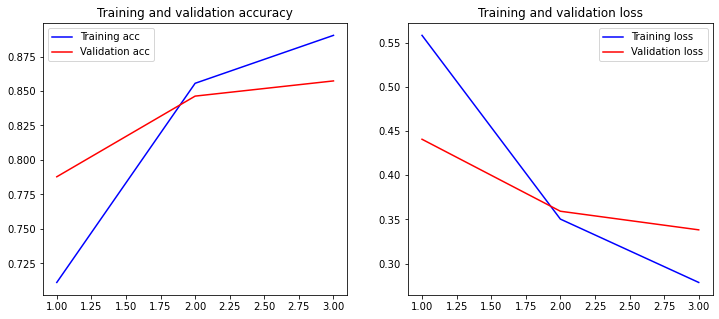

In [63]:
binary_cnn_lstm_clf_raw = build_cnn_lstm_1(maxlen, 100, loss='binary_crossentropy', name='raw_binary_cnn_lstm')
binary_cnn_lstm_clf_raw_history = fit_nn_classifier(binary_cnn_lstm_clf_raw, 3, X_train, X_test, 0.2)
plot_history(binary_cnn_lstm_clf_raw_history)

What a massive improvement!!!

Let us see if we can reach 90?!

In [8]:
def build_cnn_lstm_3(input_shape, embedding_output_dim, loss='categorical_crossentropy', name='raw_sequence_cnn_lstm_clf_3', summary=True):
    with tf.device('/device:GPU:0'):
        input_layer = layers.Input(shape=input_shape)
        embedding = layers.Embedding(input_dim=42026, output_dim=embedding_output_dim)(input_layer)
        g = layers.SpatialDropout1D(0.2)(embedding)
        g = layers.Conv1D(128, 3)(g)
        g = layers.SpatialDropout1D(0.3)(g)
        g = layers.Conv1D(256, 5, activation='relu')(g)
        g = layers.SpatialDropout1D(0.2)(g)
        g = layers.Bidirectional(layers.LSTM(128, return_sequences=True))(g)
        g = layers.Bidirectional(layers.LSTM(256))(g)
        g = layers.Dense(128, activation='relu')(g)
        g = layers.Dropout(0.3)(g)
        g = layers.Dense(64, activation='relu')(g)
        g = layers.Dropout(0.2)(g)
        g = layers.Dense(2, activation='softmax')(g)
        
        clf = Model(inputs=input_layer, outputs=g, name=name)
        
        clf.compile(loss=loss, 
                      optimizer='adam', 
                      metrics=['accuracy'])
        
        if summary:
            print(clf.summary())
    
    return clf

Model: "raw_sequence_cnn_lstm_clf_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 100)]             0         
_________________________________________________________________
embedding_9 (Embedding)      (None, 100, 100)          4202600   
_________________________________________________________________
spatial_dropout1d_15 (Spatia (None, 100, 100)          0         
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 98, 128)           38528     
_________________________________________________________________
spatial_dropout1d_16 (Spatia (None, 98, 128)           0         
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 94, 256)           164096    
_________________________________________________________________
spatial_dropout1d_17 (Spatia (None, 94,

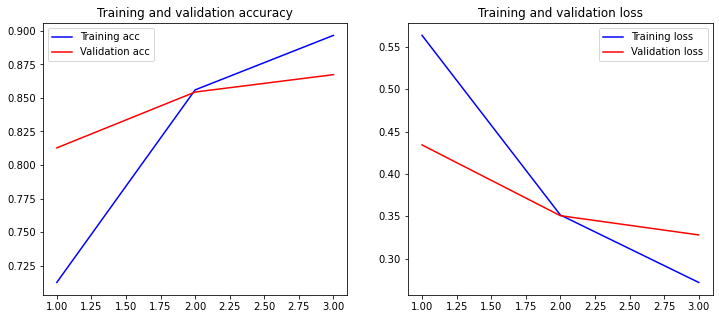

In [65]:
binary_cnn_lstm_clf_raw_1 = build_cnn_lstm_3(maxlen, 100, loss='binary_crossentropy')
binary_cnn_lstm_clf_raw_history_1 = fit_nn_classifier(binary_cnn_lstm_clf_raw_1, 3, X_train, X_test, 0.2, verbose=1)
plot_history(binary_cnn_lstm_clf_raw_history_1)

In [3]:
def testing_result(path):
    test_df = pd.read_csv(path, encoding='latin1')
    
    text_series = test_df['OriginalTweet']
    text_series = text_series.apply(replace_mentions)
    text_series = text_series.apply(replace_urls)
    text_series = text_series.apply(simplify_punctuation)
    text_series = text_series.apply(remove_whitespace_duplicate)
    text_series = text_series.apply(remove_contractions)
    
    test_df['OriginalTweet'] = text_series
    
    sentiment_series = test_df['Sentiment'].copy()
    
    sentiment_series[sentiment_series == 'Extremely Negative'] = 'Negative'

    sentiment_series[sentiment_series == 'Neutral'] = 'Positive'

    sentiment_series[sentiment_series == 'Extremely Positive'] = 'Positive'
    
    test_df['Sentiment'] = sentiment_series
    
    label_encoder = LabelEncoder()

    label_encoder.fit(test_df['Sentiment'])
    
    test_df['Sentiment'] = label_encoder.transform(test_df['Sentiment'])
    
    tokenizer = pickle.load(open('raw_tokenizer.pkl', 'rb'))
    
    X_test = tokenizer.texts_to_sequences(test_df['OriginalTweet'])
    
    X_test = pad_sequences(X_test, padding='post', maxlen=100)
    
    y_test = to_categorical(test_df['Sentiment'])
    
    clf = build_cnn_lstm_3(100, 100, loss='binary_crossentropy', summary=False)
    
    clf.load_weights(f'{clf.name}.h5')
        
    with tf.device('/device:GPU:0'):
        y_pred = clf.predict(X_test)
    
    y_pred_sk = np.argmax(y_pred, axis=1)
    
    y_test_sk = np.argmax(y_test, axis=1)
    
    print('accuracy score on test: ', accuracy_score(y_test_sk, y_pred_sk))

# Classifiers table

NUM|Classifier Type |loss|Classifier vectorizer|Data Type|Balanced Accuracy | Accuracy|
---|:---------------:|:----:|:--------------------:|:--------:|:-----------------:|:--------:|
01|NuSVC|-|tfidf|Mulitclass|39%|40%|
02|Multinomial naive bayes|-|tfidf|Mulitclass|31%|40%|
03|NuSVC|-|BOW|Mulitclass|61%|61%|
04|Multinomial naive bayes|-|BOW|Mulitclass|45%|47%|
05|Feed Forward NN (baseline)|Cross entropy|BOW|Multiclass|61%|60%|
06|Encoder-Decoder NN|Cross entropy|BOW|Multiclass|64%|65%|
07|Encoder-Decoder NN|L1|Embedding|Multiclass|60%|60%|
08|Encoder-Decoder NN|Cross entropy|Embedding|Multiclass|59%|59%|
08|Feed Forward NN|Cross entropy|Embedding|Multiclass|57%|57%|
10|CNN|Cross entropy|Embedding|Multiclass|66%|64%|
11|CNN|Cross entropy|Embedding|Multiclass|63%|64%|
12|LSTM (baseline)|Cross entropy|Embedding|Multiclass|69%|68%|
13|LSTM|Cross entropy|Embedding|Multiclass|69%|69%|
14|CNN-LSTM|Cross entropy|Embedding|Multiclass|70%|70%|
15|CNN-LSTM|Cross entropy|Embedding|Multiclass|68%|67%|
16|CNN-LSTM|Cross entropy|Embedding|Multiclass (raw)|72%|73%|
17|CNN-LSTM|Cross entropy|Embedding|Binray (raw)|84%|85%|
18|CNN-LSTM|Cross entropy|Embedding|Binray (raw)|85%|86%|

In [67]:
cleaning_result(["hello!!?" , "hi! I am using whatsapp."])

['hello!?', 'hi! using whatsapp.']

In [5]:
testing_result('Covid_19_tweets_train.csv')

accuracy score on test:  0.9048521515173603
